### Excercise (Likelihood of a good review)

Based on 

**Kaggle Dataset** : https://www.kaggle.com/grouplens/movielens-20m-dataset

I have developed a Movie Ranker following :

* The user ratings have been transformed from an scale 1-5 into 0-1. In which 1 >= 4 , otherwise 0.



* I have used my personal computer for this project, so in order to maintain the resources in control keeping the main idea of the excercise ["create a movie ranker" based on Kaggle's 20M Movielens Data],  I just used a sample of 500,000 ratings from the entire dataset.



**Summary**: In order to create the Movie Ranker there will be used a Deep Cross Network (DCN) on Tensorflow. As the dataset lacks of user demographic info ( atributes like gender, age, country) could not been tested on behave of improve performance. Notwithstanding, with a Recall mean of 75.71% under a standar deviation (std) of 0.24%, there should be an answer for each user. 
             
       

#### Packages used


In [1]:
import os
import sys


import pandas as pd
import numpy  as np
import matplotlib.pyplot  as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
import seaborn as sns
from typing import Dict, Text
import itertools
import datetime
import time


#### Data loading

In [2]:
#Movie-tag relevance data
movie_tag_rel=pd.read_csv('genome_scores.csv')

#Tag descriptions

tag_desc=pd.read_csv('genome_tags.csv')

#Movie information

Movie_info=pd.read_csv('movie.csv')


#Tags Given by users 

tags_given=pd.read_csv('tag.csv')


#Ratings Given by users
ratings_given=pd.read_csv('rating.csv')

#link to other sources

links=pd.read_csv('link.csv')




### 1.1 Data preparation 

#### Rating Sample  (undersample)

In [3]:
# Original shape (20 Million ratings )
print("Ratings shape: ",ratings_given.shape)

print(" ")

# Memory usage 
print("Memory used in MB by the 20M Dataset: ") 
ratings_given.memory_usage(index=False)*10**(-6)

Ratings shape:  (20000263, 4)
 
Memory used in MB by the 20M Dataset: 


userId       160.002104
movieId      160.002104
rating       160.002104
timestamp    160.002104
dtype: float64

In [4]:
# Downsampling of the ratings (uniform distribution sample) 

np.random.seed(50)
ratings_given0=ratings_given
ratings_given=ratings_given.sample(n=500000,axis=0,random_state=50)

In [5]:
# Resulting Shape after sampling  
print("Ratings shape: ",ratings_given.shape)

print(" ")


# Memory usage 
print("Memory used in MB by the 500K Dataset: ") 
ratings_given.memory_usage(index=False)*10**(-6)

Ratings shape:  (500000, 4)
 
Memory used in MB by the 500K Dataset: 


userId       4.0
movieId      4.0
rating       4.0
timestamp    4.0
dtype: float64

### 1.2 Descriptive analysis

In [6]:
ratings_given.head()

,userId,movieId,rating,timestamp
2482910,16811,55247,5.0,2014-07-01 02:40:43
14888745,102866,170,3.0,1997-11-19 14:14:17
19897837,137772,266,4.0,2000-03-19 18:30:40
13745487,94974,2324,4.0,1999-12-30 06:52:35
543886,3663,319,2.5,2004-09-06 15:06:40


It is important to say that rating is not a numerical feature, indeed It represents categories from worst to excellent according  user appreciation 

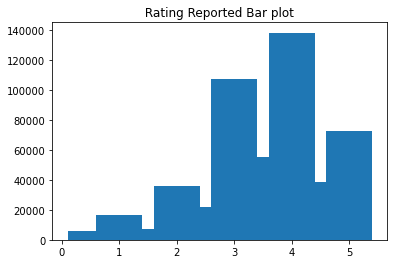

In [7]:
plt.bar(ratings_given[['movieId','rating']].groupby(['rating']).count().index.values,height=np.ravel(ratings_given[['movieId','rating']].groupby(['rating']).count().values))
plt.title(' Rating Reported Bar plot ')
plt.show()

In [8]:
tags_given.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [9]:
tags_given[['tag','userId']].groupby(['tag']).count().sort_values('userId',ascending=False)

,userId
tag,
sci-fi,3384
based on a book,3281
atmospheric,2917
comedy,2779
action,2657
...,...
Toby Jones,1
Tobacco Industry,1
Toa Fraser,1


In [10]:
tag_desc.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [11]:
Movie_info.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [12]:
# there are 27,278 diffent movies in the dataset
Movie_info.shape

(27278, 3)

In [13]:
movie_tag_rel.head(10)

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675
5,1,6,0.21700
6,1,7,0.06700
7,1,8,0.26275
8,1,9,0.26200
9,1,10,0.03200


In [14]:
print("NaN Values: " , movie_tag_rel['relevance'].isna().sum())
movie_tag_rel['relevance'].describe()


NaN Values:  0


count    1.170977e+07
mean     1.164833e-01
std      1.542463e-01
min      2.500000e-04
25%      2.425000e-02
50%      5.650000e-02
75%      1.415000e-01
max      1.000000e+00
Name: relevance, dtype: float64

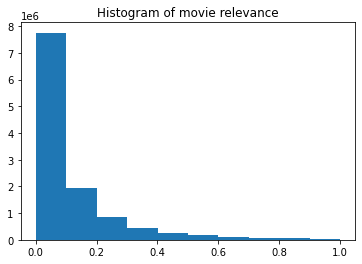

In [15]:
plt.hist(movie_tag_rel['relevance'])
plt.title('Histogram of movie relevance')
plt.show()

#### Feature Engineering

In [16]:

ratings_given['timestamp_numeric']=np.array([datetime.datetime.toordinal(datetime.datetime.fromisoformat(ratings_given['timestamp'].iloc[i])) for i in range(ratings_given.shape[0])])
ratings_given['weekday_numeric']=np.array([datetime.datetime.weekday(datetime.datetime.fromisoformat(ratings_given['timestamp'].iloc[i])) for i in range(ratings_given.shape[0])])
ratings_given['day_numeric']=np.array([(datetime.datetime.fromisoformat(ratings_given['timestamp'].iloc[i])).day for i in range(ratings_given.shape[0])])
ratings_given['month_numeric']=np.array([(datetime.datetime.fromisoformat(ratings_given['timestamp'].iloc[i])).month for i in range(ratings_given.shape[0])])
ratings_given['year_numeric']=np.array([(datetime.datetime.fromisoformat(ratings_given['timestamp'].iloc[i])).year for i in range(ratings_given.shape[0])])


These descriptive analysis are made to understand the patterns of the features created  

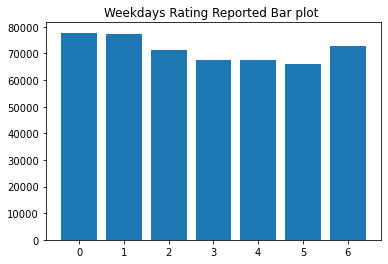

In [17]:
plt.bar(ratings_given[['movieId','weekday_numeric']].groupby(['weekday_numeric']).count().index.values,height=np.ravel(ratings_given[['movieId','weekday_numeric']].groupby(['weekday_numeric']).count().values))
plt.title('Weekdays Rating Reported Bar plot ')
plt.show()

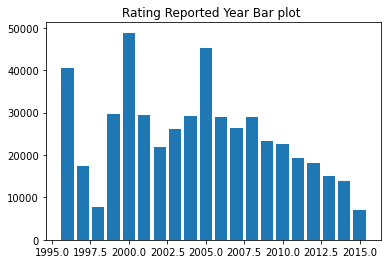

In [18]:
plt.bar(ratings_given[['movieId','year_numeric']].groupby(['year_numeric']).count().index.values,height=np.ravel(ratings_given[['movieId','year_numeric']].groupby(['year_numeric']).count().values))
plt.title('Rating Reported Year Bar plot ')
plt.show()

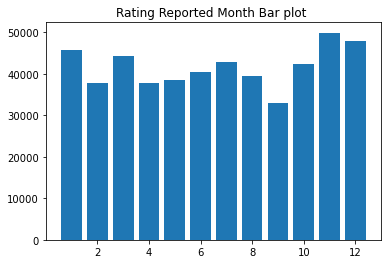

In [19]:
plt.bar(ratings_given[['movieId','month_numeric']].groupby(['month_numeric']).count().index.values,height=np.ravel(ratings_given[['movieId','month_numeric']].groupby(['month_numeric']).count().values))
plt.title('Rating Reported Month Bar plot ')
plt.show()

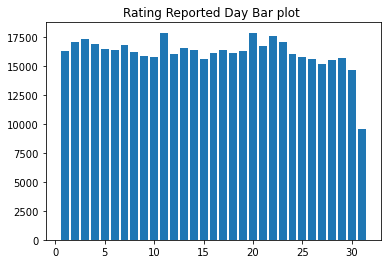

In [20]:
plt.bar(ratings_given[['movieId','day_numeric']].groupby(['day_numeric']).count().index.values,height=np.ravel(ratings_given[['movieId','day_numeric']].groupby(['day_numeric']).count().values))
plt.title('Rating Reported Day Bar plot ')
plt.show()

####  Rating uniqueness for user-movie pair

In [21]:
useful_study=ratings_given[['movieId','userId','rating']].groupby(['movieId','userId']).agg( {'rating': [min , max] } )

In [22]:
np.sum(useful_study['rating'][max]-useful_study['rating'][min])

0.0

Indeed there are unique, in case that would not , It could be prepared the min value as the actual ones

####  Rating validation

In [23]:
np.sum(ratings_given['rating'].isnull())

0

In [24]:
np.sum(ratings_given['rating'].isna())

0

### 1.3 Cleaning criteria

#### Undersampling  cleaning

In [25]:
revision_ratings=ratings_given[['movieId','userId']].groupby('userId').count()
print(revision_ratings.sort_values('movieId'))

        movieId
userId         
56110         1
76950         1
34014         1
34013         1
34012         1
...         ...
131904      146
121535      150
74142       153
118205      194
8405        194

[107079 rows x 1 columns]


As I performed an undersampling over the 20 million ratings, there are some users that do not have enough ratings to be compared with others. People with just one movie rated cannot be valid enough to proceed with a good  referral movie. For bias evadeness , will be required those **selected to have already 3 movies rated in the train - test sample**.

In [26]:
rev1=[ ratings_given[ratings_given['userId'].values == i ].index.values  for i in revision_ratings[revision_ratings['movieId']>3].index.values ]
ratings_given1=ratings_given.filter(list(itertools.chain(*rev1)), axis=0) 

In [27]:
ratings_given1.head(10)

,userId,movieId,rating,timestamp,timestamp_numeric,weekday_numeric,day_numeric,month_numeric,year_numeric
167,1,7757,4.0,2005-04-02 23:50:19,732038,5,2,4,2005
13,1,337,3.5,2004-09-10 03:08:29,731834,4,10,9,2004
111,1,3996,4.0,2004-09-10 03:08:47,731834,4,10,9,2004
20,1,924,3.5,2004-09-10 03:06:38,731834,4,10,9,2004
28,1,1136,3.5,2005-04-02 23:30:09,732038,5,2,4,2005
27,1,1097,4.0,2005-04-02 23:48:21,732038,5,2,4,2005
35,1,1214,4.0,2004-09-10 03:12:57,731834,4,10,9,2004
386,3,2615,4.0,1999-12-14 12:53:25,730102,1,14,12,1999
413,3,2968,5.0,1999-12-11 13:41:12,730099,5,11,12,1999
362,3,2236,4.0,1999-12-11 13:18:12,730099,5,11,12,1999


In [28]:
ratings_given1.shape

(385013, 9)

The reduction of the rating sample is unavoidable, to satisfy the minimum requirement imposed

#### Tags selected

In [29]:
movie_tag_rel1=movie_tag_rel.sort_values(['movieId','relevance'],axis=0,ascending=[True,False])

In [30]:
movie_tag_rel1.head(10)

,movieId,tagId,relevance
1035,1,1036,0.99925
243,1,244,0.99850
785,1,786,0.99600
588,1,589,0.99075
63,1,64,0.98575
587,1,588,0.97925
784,1,785,0.96675
203,1,204,0.96425
185,1,186,0.95650
535,1,536,0.94200


There should be imposed another cleaning criteria in the movie tags , as they were created by users and not all the movies have the same quantity of viewers. In this case, **there will be used the top 5 most relevant tags to categorise the movie in the model** 

In [31]:
movie_tag_rel1_0=([ movie_tag_rel1[movie_tag_rel1['movieId']==i].index.values[0:5]    for i in movie_tag_rel1['movieId'].unique()     ])

In [32]:
movie_tag_rel1_1=movie_tag_rel1.filter(list(itertools.chain(*movie_tag_rel1_0)), axis=0) 

As the neural network complexity increases based on quantity of nodes and layers , there will be imposed another filter: **Just take the most relevant tags in the dataset , in this case those from  above 400 uses** 

In [33]:
filterto_use1=movie_tag_rel1_1[['movieId','tagId']].groupby(['tagId']).count().sort_values('movieId',ascending=False)


In [34]:

print((filterto_use1[filterto_use1 > 400]).count())
(filterto_use1[filterto_use1 > 400]).head(10)

movieId    7
dtype: int64


,movieId
tagId,
742,1618.0
230,938.0
270,643.0
522,547.0
19,522.0
846,477.0
107,471.0
22,NaN
646,NaN


The final tags to use in the modelling will be:

In [35]:
filterto_use1.iloc[range(7),:].merge(tag_desc,on='tagId',how='inner')

,tagId,movieId,tag
0,742,1618,original
1,230,938,comedy
2,270,643,criterion
3,522,547,horror
4,19,522,action
5,846,477,relationships
6,107,471,based on a book


In [36]:
# filterto_use1['movieId'].describe()
# important_columns=filterto_use1[filterto_use1['movieId']>=25].index.values

In [37]:

movie_tag_rel1_2=movie_tag_rel1_1.pivot(index='movieId',columns='tagId',values='relevance')

In [38]:
movie_tag_rel1_2.iloc[0,:][movie_tag_rel1_2.iloc[0,:].isna()==False]

tagId
64      0.98575
244     0.99850
589     0.99075
786     0.99600
1036    0.99925
Name: 1, dtype: float64

In [39]:
movie_tag_rel1_2.shape

(10381, 1056)

In [40]:
 movie_tag_rel1_2['movieId']=movie_tag_rel1_2.index.values


In [41]:
movie_tag_rel1_2.set_axis([np.arange((movie_tag_rel1_2.shape[0]))],axis=0)
movie_tag_rel1_2.rename_axis("rownames",axis=0,inplace=True)
movie_tag_rel1_2.fillna(0,inplace=True)

movie_tag_rel1_3=movie_tag_rel1_2.iloc[:,[ i for i in range(movie_tag_rel1_2.shape[1]-1) if np.sum(movie_tag_rel1_2.iloc[:,i]>0) > 25 ]]
movie_tag_rel1_3=pd.concat([movie_tag_rel1_3,movie_tag_rel1_2.iloc[:,movie_tag_rel1_2.shape[1]-1]],axis=1)
movie_tag_rel1_3.set_axis(['_'.join(['X',str(movie_tag_rel1_3.columns[i])]) for i in np.arange(0,movie_tag_rel1_3.shape[1])],axis=1,inplace=True)

#### Putting everything in a data frame 

In [42]:
ratings_given1_2=ratings_given1.merge(movie_tag_rel1_3,left_on='movieId',right_on='X_movieId' ,how='inner')
ratings_given=ratings_given1_2

In [43]:
ratings_given1_2.head()

,userId,movieId,rating,timestamp,timestamp_numeric,weekday_numeric,day_numeric,month_numeric,year_numeric,X_1,...,X_1118,X_1119,X_1121,X_1122,X_1123,X_1125,X_1126,X_1127,X_1128,X_movieId
0,1,7757,4.0,2005-04-02 23:50:19,732038,5,2,4,2005,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7757
1,5352,7757,2.5,2005-05-30 22:32:54,732096,0,30,5,2005,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7757
2,16938,7757,3.5,2007-06-12 07:27:45,732839,1,12,6,2007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7757
3,21730,7757,3.0,2005-07-09 01:46:22,732136,5,9,7,2005,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7757
4,30967,7757,3.5,2005-03-22 21:40:50,732027,1,22,3,2005,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7757


In [44]:
np.min(np.array([movie_tag_rel1_3.transpose().iloc[:,i].sum() for i in np.arange(0,movie_tag_rel1_3.transpose().shape[1]-1)]))

3.975

#### Finally lets create the response variable (0-1) from the 1-5 ratings

In [45]:

ratings_given['Positive_ratings']=ratings_given['rating'].apply(lambda x: 1 if x>= 4 else 0)
ratings_given['Positive_ratings'].sum()

183408

In [46]:
Movie_info['title']

0                          Toy Story (1995)
1                            Jumanji (1995)
2                   Grumpier Old Men (1995)
3                  Waiting to Exhale (1995)
4        Father of the Bride Part II (1995)
                        ...                
27273          Kein Bund für's Leben (2007)
27274         Feuer, Eis & Dosenbier (2002)
27275                    The Pirates (2014)
27276                   Rentun Ruusu (2001)
27277                      Innocence (2014)
Name: title, Length: 27278, dtype: object

In [47]:
Movie_ratings_given=Movie_info.merge(ratings_given,on="movieId" ,how="inner")
Movie_ratings_given.head(5)

,movieId,title,genres,userId,rating,timestamp,timestamp_numeric,weekday_numeric,day_numeric,month_numeric,...,X_1119,X_1121,X_1122,X_1123,X_1125,X_1126,X_1127,X_1128,X_movieId,Positive_ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,16,3.0,2001-05-27 13:22:52,730632,6,27,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,489,5.0,1999-03-07 14:15:46,729820,6,7,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,588,4.0,2006-03-29 17:45:33,732399,2,29,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,603,4.0,1997-02-23 10:55:37,729078,6,23,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,631,4.0,2013-01-13 18:11:24,734881,6,13,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [48]:
Movie_ratings_given.shape

(380490, 543)

In [49]:
release_date=[]
for i in range(len(Movie_ratings_given['title'])):
    if len(Movie_ratings_given['title'][i].split("("))>1 :
        release_date.append(int(Movie_ratings_given['title'][i].split("(")[len(Movie_ratings_given['title'][i].split("(") )-1].split(")")[0]))
    else:
        release_date.append(None)
        
    
    
Movie_ratings_given['release_year']=np.array(release_date)
#(np.array([Movie_ratings_given['title'][i].split("(")[1].split(")")[0] for i in range(len(Movie_ratings_given['title'])) if len(Movie_ratings_given['title'][i].split("("))>1  ]))

In [50]:
Movie_ratings_given.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp',
       'timestamp_numeric', 'weekday_numeric', 'day_numeric', 'month_numeric',
       ...
       'X_1121', 'X_1122', 'X_1123', 'X_1125', 'X_1126', 'X_1127', 'X_1128',
       'X_movieId', 'Positive_ratings', 'release_year'],
      dtype='object', length=544)

In [51]:
#max(Movie_ratings_given['year_numeric']-Movie_ratings_given['release_year'])
Movie_ratings_given[(Movie_ratings_given['year_numeric']-Movie_ratings_given['release_year'])==-1]

,movieId,title,genres,userId,rating,timestamp,timestamp_numeric,weekday_numeric,day_numeric,month_numeric,...,X_1121,X_1122,X_1123,X_1125,X_1126,X_1127,X_1128,X_movieId,Positive_ratings,release_year
85078,981,Dangerous Ground (1997),Drama,25878,3.0,1996-10-23 10:49:18,728955,2,23,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,981,0,1997
85082,981,Dangerous Ground (1997),Drama,131678,3.0,1996-10-10 08:53:13,728942,3,10,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,981,0,1997
85171,987,Bliss (1997),Drama|Romance,43041,3.0,1996-11-29 08:04:13,728992,4,29,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,987,0,1997
85174,987,Bliss (1997),Drama|Romance,109145,2.0,1996-10-20 10:24:00,728952,6,20,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,987,0,1997
375499,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,123609,4.0,2011-09-21 22:47:54,734401,2,21,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89745,1,2012


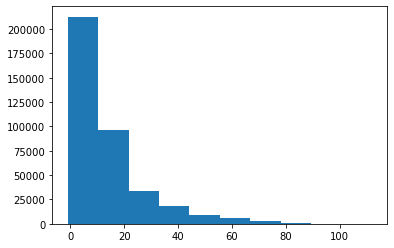

In [52]:
plt.hist(Movie_ratings_given['year_numeric']-Movie_ratings_given['release_year'])
plt.show()

In [53]:
Movie_ratings_given_1=Movie_ratings_given[(Movie_ratings_given['year_numeric']-Movie_ratings_given['release_year']<=5) ]
Movie_ratings_given=Movie_ratings_given_1[(Movie_ratings_given_1['year_numeric']-Movie_ratings_given_1['release_year']>=0)]


In [54]:
Movie_ratings_given.shape

(138813, 544)

Note: the timestamp have a data type not valid for the tensors, as I already catched some  information of interes from it, there is no reason to keep it.

In [55]:
Movie_ratings_given['userId']=Movie_ratings_given['userId'].astype('str')
Movie_ratings_given['movieId']=Movie_ratings_given['movieId'].astype('str')




#Movie_ratings_given=Movie_ratings_given.drop('timestamp',axis=1)

<ipython-input-55-195c0647d5d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Movie_ratings_given['userId']=Movie_ratings_given['userId'].astype('str')
<ipython-input-55-195c0647d5d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Movie_ratings_given['movieId']=Movie_ratings_given['movieId'].astype('str')


In [56]:
Movie_ratings_given.describe()

,rating,timestamp_numeric,weekday_numeric,day_numeric,month_numeric,year_numeric,X_1,X_2,X_3,X_5,...,X_1119,X_1121,X_1122,X_1123,X_1125,X_1126,X_1127,X_1128,X_movieId,Positive_ratings
count,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000,...,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000,138813.000000
mean,3.440481,731597.550799,2.921254,15.650443,6.789796,2003.523445,0.005371,0.006174,0.004818,0.001906,...,0.007312,0.007023,0.003427,0.004104,0.006044,0.005427,0.002163,0.004485,19347.291673,0.465137
std,1.044740,1819.203227,2.042227,8.756201,3.536815,5.020724,0.073073,0.078026,0.068125,0.042078,...,0.084031,0.082918,0.057598,0.061634,0.077241,0.072729,0.045432,0.065805,28564.240476,0.498785
min,0.500000,728687.000000,0.000000,1.000000,1.000000,1996.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3.000000,730175.000000,1.000000,8.000000,4.000000,2000.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1573.000000,0.000000
50%,3.500000,731473.000000,3.000000,16.000000,7.000000,2003.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4267.000000,0.000000
75%,4.000000,732940.000000,5.000000,23.000000,10.000000,2007.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33896.000000,1.000000
max,5.000000,735688.000000,6.000000,31.000000,12.000000,2015.000000,0.999750,1.000000,0.998000,0.976250,...,0.998500,0.999000,0.997500,0.980000,0.999750,0.996250,0.986000,0.991500,130496.000000,1.000000


In [57]:
Movie_ratings_given.head()

,movieId,title,genres,userId,rating,timestamp,timestamp_numeric,weekday_numeric,day_numeric,month_numeric,...,X_1121,X_1122,X_1123,X_1125,X_1126,X_1127,X_1128,X_movieId,Positive_ratings,release_year
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,489,5.0,1999-03-07 14:15:46,729820,6,7,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1995
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,603,4.0,1997-02-23 10:55:37,729078,6,23,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1995
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,936,4.0,1999-10-02 00:18:51,730029,5,2,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1995
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1058,5.0,1996-11-26 10:15:04,728989,1,26,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1995
15,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2430,5.0,1996-06-02 16:21:29,728812,6,2,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1995


In [58]:
Movie_ratings_given['weekday_numeric'].dtype

dtype('int64')

In [59]:
Movie_ratings_given['release_year']=Movie_ratings_given['release_year'].astype(float)

<ipython-input-59-1031640d5879>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Movie_ratings_given['release_year']=Movie_ratings_given['release_year'].astype(float)


In [60]:
Movie_ratings_given['month_numeric']

1          3
3          2
6         10
7         11
15         6
          ..
380485     2
380486     3
380487     3
380488     3
380489     3
Name: month_numeric, Length: 138813, dtype: int64

#### Ready to setup Tensorflow tensors. (Here I included all the data that will be used in the modelling)

In [61]:



rating_tf=tf.data.Dataset.from_tensor_slices(dict(Movie_ratings_given))

rating_tf=rating_tf.map(lambda x: {
    'title' : x['title'],
    'userId' : x['userId'],
    'Positive_ratings' : x['Positive_ratings'],
     'X_742': int(x['X_742']) , 
    'X_230': int(x['X_230'])  ,
    'X_270': int(x['X_270'])  ,
    'X_522': int(x['X_522'])  ,
    'X_19': int(x['X_19'])  ,
    'X_107': int(x['X_107'])  ,
    'X_846': int(x['X_846'])  ,
    'weekday_numeric' : int(x['weekday_numeric']),
    'month_numeric' : int(x['month_numeric']),
    'timestamp_numeric':int(x['timestamp_numeric'])
    
}
    
)


movies_tf=tf.data.Dataset.from_tensor_slices(dict(Movie_ratings_given))

movies_tf=movies_tf.map(lambda x: x['title']

             )

There are many other tags that could be included into the modelling , however for memory allocation sake will be used only if it is needed

#### Modelling (Model contains some feature processing)


As it could be seen in the previous section, the weekdays and months were already enconded into numerical catergories. I will work with them without additional transformations (Normalizations) as they represent literal strings. I just will use them as dictionaries in the cross networks development


In [62]:
feature_names = [ "weekday_numeric", "X_742","X_230","X_270","X_522","X_19","X_107","X_846","title", "userId","month_numeric","timestamp_numeric"] #"timestamp_numeric",

vocabularies = {}

for feature_name in feature_names:
  vocab = rating_tf.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))


In [63]:
class DCN(tfrs.Model):
    def __init__(self,use_cross_layer,deep_layer_sizes,projection_dim=None):
        super().__init__()
        
        self.embedding_dimension=32
        
        #features declaration 
        str_features=["title","userId"]
        int_features=["weekday_numeric", "X_742","X_230","X_270","X_522","X_19","X_107","X_846","month_numeric","timestamp_numeric"] #"timestamp_numeric"
        
        
        
        self._all_features= str_features + int_features
        
        #feature embedding dictionaries 
        
        self._embeddings={}
        
        for feature_name in str_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=vocabulary, mask_token=None),
            tf.keras.layers.Embedding(len(vocabulary) + 1,self.embedding_dimension)
            ])
            
                
        for feature_name in int_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.IntegerLookup(vocabulary=vocabulary, mask_token=None),
            tf.keras.layers.Embedding(len(vocabulary) + 1,self.embedding_dimension)
            ])
            
        ## Cross layer creation (in case that is activated) <- to use combined features

            
        if use_cross_layer:
            self._cross_layer=tfrs.layers.dcn.Cross(
                projection_dim=projection_dim,
                kernel_initializer='glorot_uniform'
            )
        else:
            self._cross_layer=None
            
        
        ## Deep network creation (it is always working for ranking purpouses)
        
        self._deep_layers=[tf.keras.layers.Dense(layer_size,activation="relu") for layer_size in deep_layer_sizes]
        self._logit_layer=tf.keras.layers.Dense(1,activation="sigmoid")
        
        self.task=tfrs.tasks.Ranking(
        loss= tf.keras.losses.BinaryCrossentropy(from_logits=True), #tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.Recall()]#tf.keras.metrics.RootMeanSquaredError("RMSE")
        )
            
  

    def call(self, features):
        embeddings=[]
        for feature_name in self._all_features:
            embedding_fn=self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))
            
        x=(tf.concat(embeddings,axis=1))
        
        
        if self._cross_layer is not None:
            x=self._cross_layer(x)
        
        
        for deep_layer in self._deep_layers:
            x=deep_layer(x)
        
        return self._logit_layer(x)
    
    
    def compute_loss(self,features , training=False):

        labels = features.pop("Positive_ratings")

        rating_predictions = self(features)

        return self.task(labels=labels,predictions=rating_predictions)

            

#### Train an Test sets (80% - 20%)

In [64]:
Movie_ratings_given.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp',
       'timestamp_numeric', 'weekday_numeric', 'day_numeric', 'month_numeric',
       ...
       'X_1121', 'X_1122', 'X_1123', 'X_1125', 'X_1126', 'X_1127', 'X_1128',
       'X_movieId', 'Positive_ratings', 'release_year'],
      dtype='object', length=544)

In [65]:
#agregar train y test cronologicos  train 1995-2009 test 2010-2015
Movie_ratings_given_train=Movie_ratings_given[Movie_ratings_given['release_year']<=2009] 
Movie_ratings_given_test=Movie_ratings_given[Movie_ratings_given['release_year']>=2010] 

In [66]:
print("train shape",Movie_ratings_given_train.shape)
print("test shape",Movie_ratings_given_test.shape)


train shape (128960, 544)
test shape (9853, 544)


In [67]:


rating_tf_train=tf.data.Dataset.from_tensor_slices(dict(Movie_ratings_given_train))

rating_tf_train=rating_tf_train.map(lambda x: {
    'title' : x['title'],
    'userId' : x['userId'],
    'Positive_ratings' : x['Positive_ratings'],
     'X_742': int(x['X_742']) , 
    'X_230': int(x['X_230'])  ,
    'X_270': int(x['X_270'])  ,
    'X_522': int(x['X_522'])  ,
    'X_19': int(x['X_19'])  ,
    'X_107': int(x['X_107'])  ,
    'X_846': int(x['X_846'])  ,
    'weekday_numeric' : int(x['weekday_numeric']),
    'month_numeric' : int(x['month_numeric']),
    'timestamp_numeric':int(x['timestamp_numeric'])
    
}
    
)

rating_tf_test=tf.data.Dataset.from_tensor_slices(dict(Movie_ratings_given_test))

rating_tf_test=rating_tf_test.map(lambda x: {
    'title' : x['title'],
    'userId' : x['userId'],
    'Positive_ratings' : x['Positive_ratings'],
     'X_742': int(x['X_742']) , 
    'X_230': int(x['X_230'])  ,
    'X_270': int(x['X_270'])  ,
    'X_522': int(x['X_522'])  ,
    'X_19': int(x['X_19'])  ,
    'X_107': int(x['X_107'])  ,
    'X_846': int(x['X_846'])  ,
    'weekday_numeric' : int(x['weekday_numeric']),
    'month_numeric' : int(x['month_numeric']),
    'timestamp_numeric':int(x['timestamp_numeric'])
    
}
    
)


In [68]:
tf.random.set_seed(50)
#385_013
shuffled = rating_tf.shuffle(138_813, seed=50, reshuffle_each_iteration=False)
#308_010
train = shuffled.take(97_169)
test = shuffled.skip(97_169).take(41_644)
#77_003


In [69]:
cached_train=rating_tf_train.shuffle(130_000).batch(8192).cache()
cached_test = rating_tf_train.shuffle(10_000).batch(4096).cache()

#### Cross-validation 

In [70]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
    models = []
    rmses = []

    for i in range(num_runs):
        model = DCN(use_cross_layer=use_cross_layer,
                    deep_layer_sizes=deep_layer_sizes,
                    projection_dim=projection_dim)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
        models.append(model)

        model.fit(cached_train, epochs=epochs, verbose=False)
        metrics = model.evaluate(cached_test, return_dict=True)
        
        rmses.append(metrics[[i for i in metrics.keys()][0]])

    mean, stdv = np.average(rmses), np.std(rmses)

    return {"model": models, "mean": mean, "stdv": stdv}


In [124]:
model = DCN(use_cross_layer=True,
                    deep_layer_sizes=[128,64],
                    projection_dim=None)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
model.fit(cached_train, epochs=epochs, verbose=False)
model.evaluate(cached_test, return_dict=True)

32/32 [==============================] - 1s 11ms/step - recall_7: 0.7507 - loss: 0.5806 - regularization_loss: 0.0000e+00 - total_loss: 0.5806


{'recall_7': 0.7506616115570068,
 'loss': 0.5708470344543457,
 'regularization_loss': 0,
 'total_loss': 0.5708470344543457}

In [125]:
m=model.evaluate(cached_test, return_dict=True)

32/32 [==============================] - 1s 12ms/step - recall_7: 0.7507 - loss: 0.5806 - regularization_loss: 0.0000e+00 - total_loss: 0.5806


#### Parameters (cross validated 5 times)


In [73]:
epochs=100
learning_rate=0.001

### 3.1 Results based on test evaluation 

In [74]:
dcn_result = run_models(use_cross_layer=True,
                        projection_dim=None,
                         deep_layer_sizes=[128,64])

32/32 [==============================] - 1s 11ms/step - recall_5: 0.7610 - loss: 0.5795 - regularization_loss: 0.0000e+00 - total_loss: 0.5795


In [75]:
print("DCN            Recall mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))


DCN            Recall mean: 0.7571, stdv: 0.0024


#### Short Explanation:

The trained model reaches a 75.71% recall on average after the change on the rating from 1-5 into 0-1.



### 3.2 Prediction for the user 631

In [92]:
Movie_ratings_given_test.head()

,movieId,title,genres,userId,rating,timestamp,timestamp_numeric,weekday_numeric,day_numeric,month_numeric,...,X_1121,X_1122,X_1123,X_1125,X_1126,X_1127,X_1128,X_movieId,Positive_ratings,release_year
370041,73268,Daybreakers (2010),Action|Drama|Horror|Thriller,3797,3.0,2010-01-19 08:23:26,733791,1,19,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73268,0,2010.0
370042,73268,Daybreakers (2010),Action|Drama|Horror|Thriller,4660,4.0,2010-06-09 05:43:19,733932,2,9,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73268,1,2010.0
370043,73268,Daybreakers (2010),Action|Drama|Horror|Thriller,9397,4.5,2010-09-12 18:01:56,734027,6,12,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73268,1,2010.0
370044,73268,Daybreakers (2010),Action|Drama|Horror|Thriller,11799,3.0,2011-02-13 23:17:06,734181,6,13,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73268,0,2010.0
370045,73268,Daybreakers (2010),Action|Drama|Horror|Thriller,30507,3.0,2015-01-25 10:40:37,735623,6,25,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73268,0,2010.0


In [ ]:
Movie_ratings_given_test[Movie_ratings_given_test['userId']=="3797"]['month_numeric'][379542]

In [87]:
Movie_ratings_given_test[Movie_ratings_given_test['userId']=="3797"]['X_846'][371388]

0.0

In [ ]:
Movie_ratings_given_test[Movie_ratings_given_test['userId']=="4660"]["title"][372375]

In [123]:
Movie_ratings_given_test[Movie_ratings_given_test['userId']=="4660"]["X_742"]

370042    0.00000
372125    0.00000
372375    0.00000
375344    0.79575
375355    0.00000
377973    0.00000
Name: X_742, dtype: float64

In [117]:
Movie_ratings_given_test[Movie_ratings_given_test['userId']=="30507"]["weekday_numeric"][377767]

4

In [94]:
Movie_ratings_given_test[Movie_ratings_given_test['userId']=="30507"]

,movieId,title,genres,userId,rating,timestamp,timestamp_numeric,weekday_numeric,day_numeric,month_numeric,...,X_1121,X_1122,X_1123,X_1125,X_1126,X_1127,X_1128,X_movieId,Positive_ratings,release_year
370045,73268,Daybreakers (2010),Action|Drama|Horror|Thriller,30507,3.0,2015-01-25 10:40:37,735623,6,25,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73268,0,2010.0
374058,85131,Battle: Los Angeles (2011),Action|Sci-Fi|War,30507,3.0,2011-08-12 08:46:17,734361,4,12,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85131,0,2011.0
374802,87298,Everything Must Go (2010),Comedy|Drama,30507,3.5,2011-09-12 19:50:37,734392,0,12,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87298,0,2010.0
375155,88672,Our Idiot Brother (2011),Comedy,30507,3.0,2015-01-25 11:41:53,735623,6,25,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88672,0,2011.0
375971,91104,"Twilight Saga: Breaking Dawn - Part 1, The (2011)",Adventure|Drama|Fantasy|Romance,30507,3.0,2015-01-25 12:10:11,735623,6,25,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91104,0,2011.0
377026,95105,Madagascar 3: Europe's Most Wanted (2012),Adventure|Animation|Children|Comedy|IMAX,30507,3.0,2015-01-24 14:51:51,735622,5,24,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95105,0,2012.0
377201,95720,"Watch, The (2012)",Comedy|Sci-Fi,30507,2.5,2015-01-24 15:02:23,735622,5,24,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95720,0,2012.0
377661,97306,Seven Psychopaths (2012),Comedy|Crime,30507,3.5,2015-01-24 08:06:00,735622,5,24,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97306,0,2012.0
377767,97913,Wreck-It Ralph (2012),Animation|Comedy,30507,4.0,2015-01-23 15:22:51,735621,4,23,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97913,1,2012.0
378842,103810,Red 2 (2013),Action|Comedy|Crime|Thriller,30507,3.0,2015-01-24 14:51:20,735622,5,24,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103810,0,2013.0


In [72]:
Movie_ratings_given_test[Movie_ratings_given_test['userId']=="3797"]

,movieId,title,genres,userId,rating,timestamp,timestamp_numeric,weekday_numeric,day_numeric,month_numeric,...,X_1121,X_1122,X_1123,X_1125,X_1126,X_1127,X_1128,X_movieId,Positive_ratings,release_year
370041,73268,Daybreakers (2010),Action|Drama|Horror|Thriller,3797,3.0,2010-01-19 08:23:26,733791,1,19,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73268,0,2010.0
371388,78209,Get Him to the Greek (2010),Comedy,3797,3.0,2010-06-06 18:16:33,733929,6,6,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78209,0,2010.0
377377,96606,Samsara (2011),Documentary,3797,3.0,2014-12-29 17:32:57,735596,0,29,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96606,0,2011.0
379363,106642,"Day of the Doctor, The (2013)",Adventure|Drama|Sci-Fi,3797,3.0,2014-12-19 16:25:54,735586,4,19,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106642,0,2013.0
379542,107348,Anchorman 2: The Legend Continues (2013),Comedy,3797,2.0,2014-06-08 05:00:36,735392,6,8,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107348,0,2013.0


In [76]:
model = DCN(use_cross_layer=True,
            deep_layer_sizes=[128,64],
            projection_dim=None
           )

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
model.fit(cached_train, epochs=epochs, verbose=False)

Example #1:

In [105]:
model({"title":np.array(["Noah (2014)"]),"userId":np.array(["30507"]),"X_742":np.array([0.0]),"X_230":np.array([0.0]),"X_270":np.array([0.0]),"X_522":np.array([0.0]),"X_19":np.array([0.0]),"X_107":np.array([0.0]),"X_846":np.array([0.0]),"weekday_numeric":np.array([5]),"month_numeric":np.array([1]),"timestamp_numeric":np.array([735622])})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[9.1850716e-10]], dtype=float32)>

In [118]:
model({"title":np.array(["Wreck-It Ralph (2012)"]),"userId":np.array(["30507"]),"X_742":np.array([0.0]),"X_230":np.array([0.0]),"X_270":np.array([0.0]),"X_522":np.array([0.0]),"X_19":np.array([0.0]),"X_107":np.array([0.0]),"X_846":np.array([0.0]),"weekday_numeric":np.array([4]),"month_numeric":np.array([1]),"timestamp_numeric":np.array([735621])})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.0220076e-10]], dtype=float32)>

In [88]:
model({"title":np.array(["Anchorman 2: The Legend Continues (2013)"]),"userId":np.array(["3797"]),"X_742":np.array([0.0]),"X_230":np.array([0.97575]),"X_270":np.array([0.0]),"X_522":np.array([0.0]),"X_19":np.array([0.0]),"X_107":np.array([0.0]),"X_846":np.array([0.0]),"weekday_numeric":np.array([6]),"month_numeric":np.array([1]),"timestamp_numeric":np.array([735392])})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.4099433e-19]], dtype=float32)>

Example #2:

In [89]:
model({"title":np.array(["Get Him to the Greek (2010)"]),"userId":np.array(["3797"]),"X_742":np.array([0.0]),"X_230":np.array([0.9815]),"X_270":np.array([0.0]),"X_522":np.array([0.0]),"X_19":np.array([0.0]),"X_107":np.array([0.0]),"X_846":np.array([0.0]),"weekday_numeric":np.array([6]),"month_numeric":np.array([6]),"timestamp_numeric":np.array([733929])})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.2897045e-22]], dtype=float32)>

In [119]:
model({"title":np.array(["Switch, The (2010)"]),"userId":np.array(["4660"]),"X_742":np.array([0.0]),"X_230":np.array([0.0]),"X_270":np.array([0.0]),"X_522":np.array([0.0]),"X_19":np.array([0.0]),"X_107":np.array([0.0]),"X_846":np.array([0.8155]),"weekday_numeric":np.array([4]),"month_numeric":np.array([4]),"timestamp_numeric":np.array([734256])})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [120]:
model({"title":np.array(["Contagion (2011)"]),"userId":np.array(["4660"]),"X_742":np.array([0.0]),"X_230":np.array([0.0]),"X_270":np.array([0.0]),"X_522":np.array([0.0]),"X_19":np.array([0.0]),"X_107":np.array([0.0]),"X_846":np.array([0.0]),"weekday_numeric":np.array([4]),"month_numeric":np.array([1]),"timestamp_numeric":np.array([734529])})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

### Explanation:

The above result 0.00567936, tell us that user **631** would be **more interested** in the movie **Paperman (2012) rather than Toy Story (1995)** with 0.00945155 score. It is important to declare both show similar interest for the user 631.

**Remember** the **tags** created by users:

In [121]:
filterto_use1.iloc[range(7),:].merge(tag_desc,on='tagId',how='inner')

,tagId,movieId,tag
0,742,1618,original
1,230,938,comedy
2,270,643,criterion
3,522,547,horror
4,19,522,action
5,846,477,relationships
6,107,471,based on a book


### 4.1 Feature Importance

<ipython-input-122-2fb279534dd5>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels( ['']+features, rotation=45, ha="left", fontsize=8)
<ipython-input-122-2fb279534dd5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels( ['']+features, fontsize=8)


<Figure size 3600x3600 with 0 Axes>

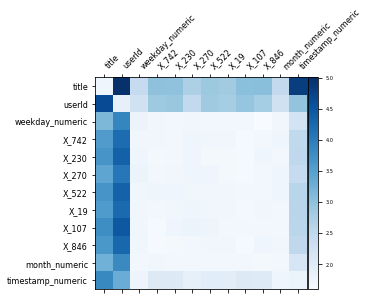

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator

model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
        for j in range(len(features)):
            block = mat[i * dim:(i + 1) * dim,
                        j * dim:(j + 1) * dim]
            block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(50,50))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.01)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=5) 
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(1))
_ = ax.set_xticklabels( ['']+features, rotation=45, ha="left", fontsize=8)
_ = ax.set_yticklabels( ['']+features, fontsize=8)

In [ ]:
features

### Explanation:

As it is expected the userId and Title are the most important features . The time features are not working well in the cross layer model.

The metric used to show the feature importance is the Euclidean Norm which is an standard  measure to locate and calculate distance between objects in R(n)